# This is an example notebook on the usage of the lstchain_create_irf_files Tool and use some basic plots to check the IRFs

To check the simple usage of the Tool, one can do the following in a terminal - 
$ lstchain_create_irf_files --help

For for more detailed help, 
$ lstchain_create_irf_files --help-all

The particles used for creating the IRFs currently are - 
* Point gamma (with 0.4 deg offset)
* Diffuse gamma
* Proton
* Electron

The MC files have discrete sky pointing direction, and hence, we need to specify the zenith and azimuth pointing, and have the MC files for the same sky direction pointing to create the IRFs.

We have been using Zenith 20 deg and Azimuth South pointing for the standard MC production with LST, but we also have few other direction pointing MC files to use.

The standard DL1/2 files are separated as *testing* and *training* files, where the DL1 *training* files are used to train the Random Forest model for the reconstruction of DL1 files to DL2, and DL2 *testing* files are used for producing the IRFs.

For cuts on gammaness and theta, one can use either fixed global cut or energy-dependent cut with fixed efficiency and containment region.

For the usage of the Tool, we also need a config file providing the event selection cuts and binning information. One can use the example config file available in `cta-lstchain/docs/examples/irf_tool_config.json` or create a similar config file for each specific use case. If the config file is not provided, the default values are used as per the Component in the file `cta-lstchain/lstchain/io/event_selection.py`.

In [1]:
%matplotlib inline
from astropy.io import fits
import astropy.units as u
from astropy.table import QTable

import matplotlib.pyplot as plt
from traitlets.config.loader import Config

from gammapy.irf import EnergyDispersion2D, EffectiveAreaTable2D, Background2D, PSF3D
from lstchain.io.config import read_configuration_file

# Input parameters to convert MC DL2 files to IRF

In [2]:
# Using the standard MC files
mc_base_dir = "/fefs/aswg/data/mc/DL2/20200629_prod5_trans_80/"

# Using the same zenith, azimuth pointing and the production version to generate the IRF
mc_pnt_n_prod = "/zenith_20deg/south_pointing/20210923_v0.7.5_prod5_trans_80_dynamic_cleaning/"

# DL2 file paths for each particle
gamma_dl2 = mc_base_dir + "gamma" + mc_pnt_n_prod + "off0.4deg/dl2_gamma_20deg_180deg_off0.4deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
gamma_diffuse_dl2 = mc_base_dir + "gamma-diffuse" + mc_pnt_n_prod + "dl2_gamma-diffuse_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
proton_dl2 = mc_base_dir + "proton" + mc_pnt_n_prod + "dl2_proton_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"
electron_dl2 = mc_base_dir + "electron" + mc_pnt_n_prod + "dl2_electron_20deg_180deg_20210923_v0.7.5_prod5_trans_80_dynamic_cleaning_testing.h5"

output_irf_path = "/fefs/aswg/workspace/analysis-school-2022/src_indep/"

# If Point-like IRFs are to be produced, value for point_like should be True, and
# for Full Enclosure IRFs, it should be False. 
# Accordingly, it will be beneficial to name the final output filename
output_irf_file = "pnt_irf_pnt_gamma_en_dep_soft_cuts.fits.gz"

# Vary the following parameters for different IRF type and cuts
config_file = "../docs/examples/irf_tool_config.json"

point_like = True
energy_dependent_gh_cuts = True
energy_dependent_theta_cuts = True

use_point_gamma = True
if not use_point_gamma:
    gamma_dl2 = gamma_diffuse_dl2

In [3]:
config = Config(read_configuration_file(config_file))
config

{'EventSelector': {'filters': {'intensity': [100, inf],
   'width': [0, inf],
   'length': [0, inf],
   'r': [0, 1],
   'wl': [0.1, 1],
   'leakage_intensity_width_2': [0, 0.2],
   'event_type': [32, 32]}},
 'DL3Cuts': {'global_gh_cut': 0.7,
  'gh_efficiency': 0.9,
  'global_theta_cut': 0.2,
  'theta_containment': 0.68,
  'allowed_tels': [1]},
 'DataBinning': {'true_energy_min': 0.01,
  'true_energy_max': 100,
  'true_energy_n_bins_per_decade': 5,
  'reco_energy_min': 0.01,
  'reco_energy_max': 100,
  'reco_energy_n_bins_per_decade': 5,
  'energy_migration_min': 0.2,
  'energy_migration_max': 5,
  'energy_migration_n_bins': 31,
  'fov_offset_min': 0.1,
  'fov_offset_max': 1.1,
  'fov_offset_n_edges': 9,
  'bkg_fov_offset_min': 0,
  'bkg_fov_offset_max': 10,
  'bkg_fov_offset_n_edges': 21,
  'source_offset_min': 0.0001,
  'source_offset_max': 1.0001,
  'source_offset_n_edges': 1000}}

In [4]:
!lstchain_create_irf_files --help-all

Create FITS file for IRFs from given MC DL2 files and selection cuts taken
either from command-line arguments or a config file.

MC gamma files can be point_like or diffuse. IRFs can be point_like or Full
Enclosure. Background HDU maybe added if proton and electron MC are provided.

Change the selection parameters as need be using the aliases. The default values
are written in the EventSelector, DL3Cuts and DataBinning Component and also
given in some example configs in docs/examples/

By default, the Tool uses global cuts for gammaness and theta.

For using energy-dependent gammaness cuts, use the argument gh_efficiency for
passing the gamma efficiency value to calculate the gammaness cuts for each reco
energy bin and the flag energy-dependent-gh. Similarly, for energy-dependent
theta cuts, use the argument theta_containment and the flag energy-dependent-
theta.

The energy-dependent cuts are stored as HDUs - GH_CUTS and RAD_MAX, and saved
with other IRFs.

To use a separate config fi

In [5]:
# Modify the arguments/flags as required 
!lstchain_create_irf_files \
--input-gamma-dl2 $gamma_dl2 \
--input-proton-dl2 $proton_dl2 \
--input-electron-dl2 $electron_dl2 \
--output-irf-file $output_irf_path/$output_irf_file \
--config $config_file \
--overwrite \
--point-like \
--energy-dependent-gh \
--energy-dependent-theta


2022-02-02 15:11:41,255 WARNING [ctapipe.IRFFITSWriter] (lstchain_create_irf_files.setup): Overwriting /fefs/aswg/workspace/analysis-school-2022/src_indep/pnt_irf_pnt_gamma_en_dep_soft_cuts.fits.gz


# Check the IRFs with some basic plots

In [6]:
fits.open(output_irf_path + output_irf_file).info()

Filename: /fefs/aswg/workspace/analysis-school-2022/src_indep/pnt_irf_pnt_gamma_en_dep_soft_cuts.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EFFECTIVE AREA    1 BinTableHDU     43   1R x 5C   [19D, 19D, D, D, 19D]   
  2  ENERGY DISPERSION    1 BinTableHDU     49   1R x 7C   [19D, 19D, 30D, 30D, D, D, 570D]   
  3  BACKGROUND    1 BinTableHDU     43   1R x 5C   [19D, 19D, 20D, 20D, 380D]   
  4  GH_CUTS       1 BinTableHDU     27   19R x 4C   [D, D, D, D]   
  5  RAD_MAX       1 BinTableHDU     43   1R x 5C   [19D, 19D, D, D, 19D]   


In [7]:
aeff_plot = EffectiveAreaTable2D.read(output_irf_path + output_irf_file, hdu="EFFECTIVE AREA")
edisp_plot = EnergyDispersion2D.read(output_irf_path + output_irf_file, hdu="ENERGY DISPERSION")
bkg_plot = Background2D.read(output_irf_path + output_irf_file, hdu="BACKGROUND")

if energy_dependent_gh_cuts:
    gh_cut = QTable.read(output_irf_path + output_irf_file, hdu="GH_CUTS")

if energy_dependent_theta_cuts:
    theta_cut = QTable.read(output_irf_path + output_irf_file, hdu="RAD_MAX")

if not point_like:
    psf_plot = PSF3D.read(output_irf_path + output_irf_file, hdu="PSF")

In [8]:
# Sample header values for IRFs
fits.open(output_irf_path + output_irf_file)["EFFECTIVE AREA"].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  472 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    5 / number of table fields                         
CREATOR = 'pyirf v0.6.0'                                                        
HDUDOC  = 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'    
HDUVERS = '0.2     '                                                            
HDUCLASS= 'GADF    '                                                            
HDUCLAS1= 'RESPONSE'        

Text(0.5, 1.0, 'Effective Area')

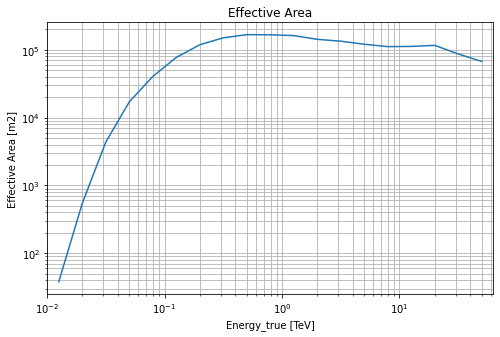

In [9]:
# Effective Area energy dependence
plt.figure(figsize=(8,5))

aeff_plot.plot_energy_dependence(offset=[0.4 * u.deg])
plt.legend().remove()
plt.yscale('log')
plt.grid(which='both')
plt.title("Effective Area")

Text(0.5, 1.0, 'Effective Area - energy offset dependence')

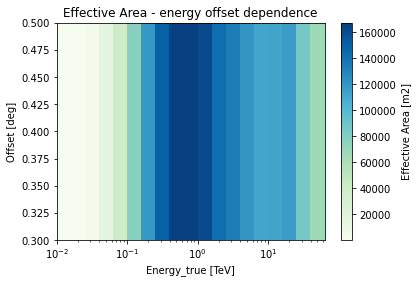

In [10]:
# Energy Offset dependence
aeff_plot.plot()
plt.title("Effective Area - energy offset dependence")

In [11]:
# Effective Area offset dependence when diffuse gamma is used
if not use_point_gamma:
    aeff_plot.plot_offset_dependence()

Text(0.5, 0.98, 'Energy migration')

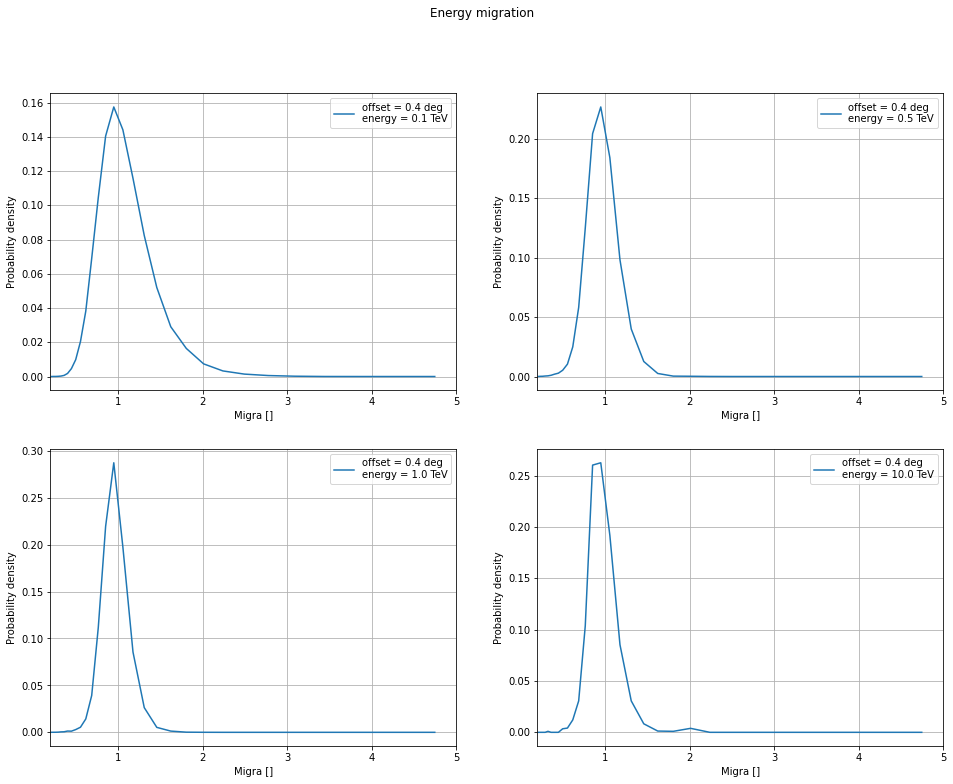

In [12]:
# Energy Dispersion, energy migratoin
plt.figure(figsize=(16,12))

offset = "0.4 deg"
true_energy = [0.1, 0.5, 1, 10] * u.TeV

plt.subplot(221)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[0])
plt.legend(loc=1)
plt.grid()

plt.subplot(222)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[1])
plt.legend(loc=1)
plt.grid()

plt.subplot(223)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[2])
plt.legend(loc=1)
plt.grid()

plt.subplot(224)
edisp_plot.plot_migration(offset=offset, energy_true=true_energy[3])
plt.legend(loc=1)
plt.grid()

plt.suptitle("Energy migration")

Text(0.5, 1.0, 'Energy Bias at 0.4 deg')

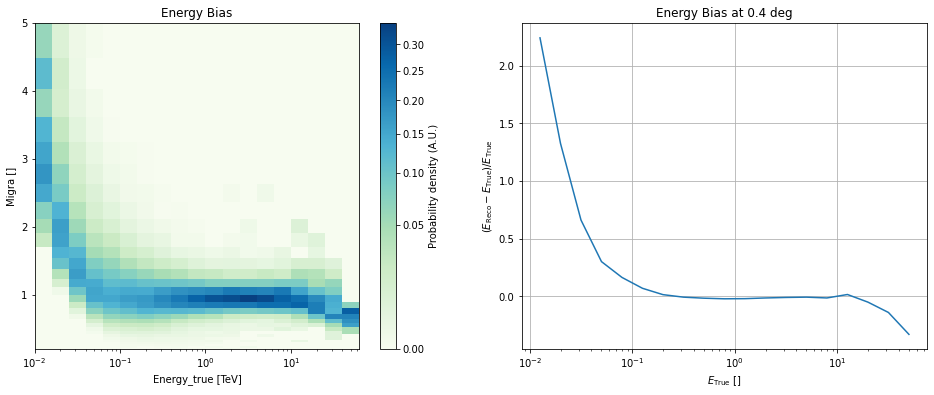

In [13]:
# Energy bias

plt.figure(figsize=(16,6))

plt.subplot(121)
edisp_plot.plot_bias(offset=offset, add_cbar=True)
plt.title("Energy Bias")

plt.subplot(122)
edisp_kernel = edisp_plot.to_edisp_kernel(offset=0.4*u.deg)
edisp_kernel.plot_bias()
plt.grid()
plt.title("Energy Bias at 0.4 deg")

Text(0.5, 1.0, 'Energy Migration Matrix')

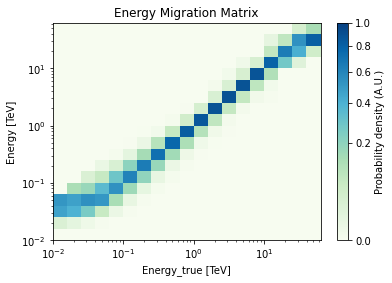

In [14]:
# Energy migration matrix
edisp_kernel.plot_matrix(add_cbar=True)
plt.title("Energy Migration Matrix")

Text(0.5, 1.0, 'Background rate - offset dependence')

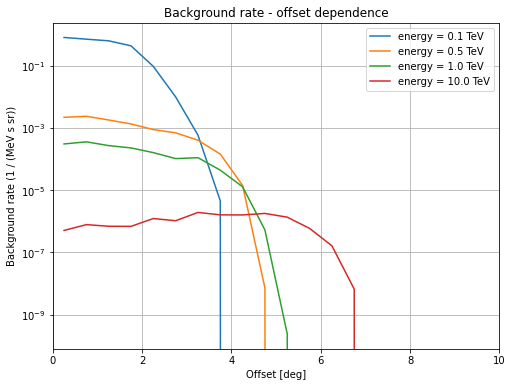

In [15]:
# Background, offset dependence
plt.figure(figsize=(8,6))

bkg_plot.plot_offset_dependence(energy=true_energy)
plt.grid(which="both")
plt.title("Background rate - offset dependence")

Text(0.5, 0.98, 'Background rate - energy dependence')

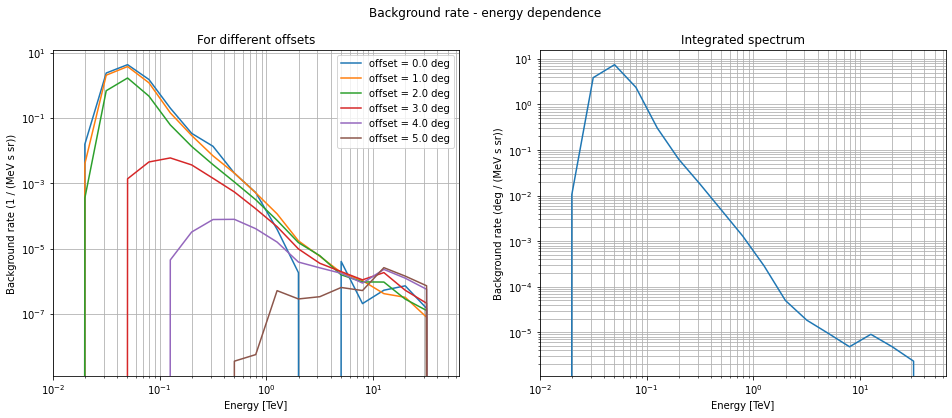

In [16]:
# Background rate energy dependence
plt.figure(figsize=(16,6))
bkg_offset = [0, 1, 2, 3, 4, 5] * u.deg

plt.subplot(121)

labels = []
for o in bkg_offset:
    bkg_plot.plot_energy_dependence(offset=[o])
    labels.append(f"offset = {o}")
plt.legend().remove()
plt.legend(labels)
plt.grid(which="both")
plt.title("For different offsets")

plt.subplot(122)
bkg_plot.plot_spectrum()
plt.grid(which="both")
plt.legend().remove()
plt.title("Integrated spectrum")

plt.suptitle("Background rate - energy dependence")

Text(0.5, 1.0, 'Background rate - energy offset dependence')

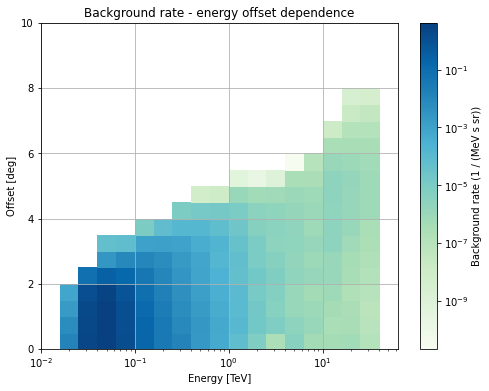

In [17]:
# Energy offset dependence
plt.figure(figsize=(8,6))
bkg_plot.plot()
plt.grid()
plt.title("Background rate - energy offset dependence")

In [18]:
if not point_like:
    psf_plot.peek()

OrderedDict([('CREATOR', 'lstchain v0.8.5.dev227+g4aa066d'), ('DATE', '2022-02-02 15:11:50.276'), ('TELESCOP', 'CTA-N'), ('INSTRUME', 'LST-1'), ('FOVALIGN', 'RADEC'), ('GH_EFF', 0.9), ('TH_CONT', 0.68), ('EXTNAME', 'GH_CUTS')])


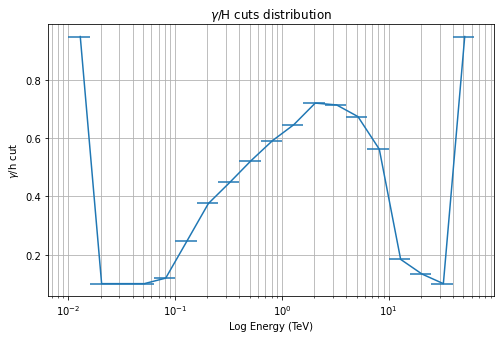

In [19]:
if energy_dependent_gh_cuts:
    print(gh_cut.meta)
    
    plt.figure(figsize=(8,5))
    
    plt.errorbar(
        gh_cut["center"], gh_cut["cut"],
        xerr=(
            gh_cut["center"] - gh_cut["low"], 
            gh_cut["high"] - gh_cut["center"]
        )
    )

    plt.xscale('log')
    plt.title(r"$\gamma$/H cuts distribution")
    plt.ylabel(r'$\gamma$/h cut')
    plt.xlabel('Log Energy (TeV)')
    plt.grid(which='both')

OrderedDict([('CREATOR', 'pyirf v0.6.0'), ('HDUDOC', 'https://github.com/open-gamma-ray-astro/gamma-astro-data-formats'), ('HDUVERS', '0.2'), ('HDUCLASS', 'GADF'), ('HDUCLAS1', 'RESPONSE'), ('HDUCLAS2', 'RAD_MAX'), ('HDUCLAS3', 'POINT-LIKE'), ('HDUCLAS4', 'RAD_MAX_2D'), ('DATE', '2022-02-02 15:11:50.285'), ('TELESCOP', 'CTA-N'), ('INSTRUME', 'LST-1'), ('FOVALIGN', 'RADEC'), ('GH_EFF', 0.9), ('TH_CONT', 0.68), ('EXTNAME', 'RAD_MAX')])


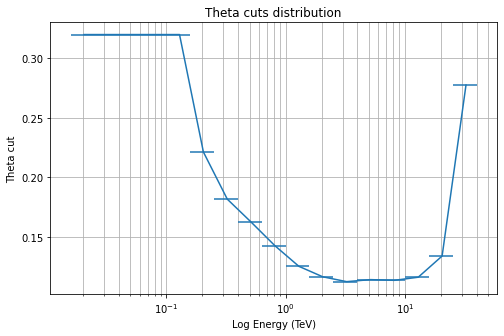

In [20]:
if energy_dependent_theta_cuts:
    print(theta_cut.meta)
    
    plt.figure(figsize=(8,5))
    plt.errorbar(
        0.5 * (theta_cut[0]['ENERG_LO'] + theta_cut[0]['ENERG_HI'])[1:-1],
        theta_cut[0]['RAD_MAX'].T[1:-1, 0],
        xerr=0.5 * (theta_cut[0]['ENERG_HI'] - theta_cut[0]['ENERG_LO'])[1:-1]
    )
    plt.xscale('log')
    plt.title("Theta cuts distribution")
    plt.ylabel('Theta cut')
    plt.xlabel('Log Energy (TeV)')
    plt.grid(which='both')